In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

In [5]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

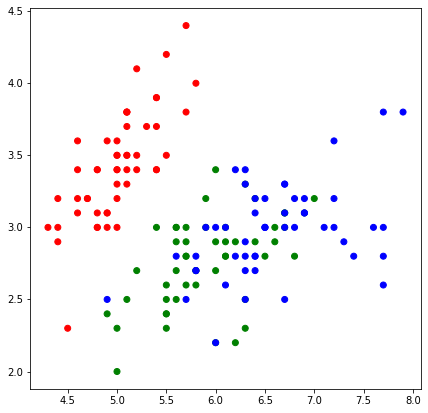

In [6]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [7]:
def e_metrics(x1, x2):    
    return np.sqrt(sum([np.square(i - j) for i, j in zip(x1, x2)]))

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

def weighted_knn_by_number(x_train, y_train, x_test, k, q=1):
    answers = []
    for x in x_test:
        test_distances = [(e_metrics(x, x_tr), y_tr) for x_tr, y_tr in zip(x_train, y_train)]
        classes = {class_item: 0 for class_item in set(y_train)}
        
        for i, d in enumerate(sorted(test_distances)[0:k], start=1):
            classes[d[1]] += q ** i

        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
def get_graph(X_train, y_train, k, q=1, func=weighted_knn_by_number):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = func(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [9]:
k = 5
q = 0.8
y_pred = weighted_knn_by_number(X_train, y_train, X_test, k, q)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.800


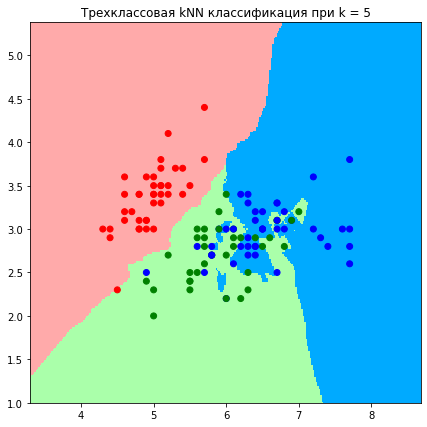

In [10]:
get_graph(X_train, y_train, k, q)

2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.
3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.

In [11]:
def weighted_knn_by_distance(x_train, y_train, x_test, k, q=1):
    answers = []
    for x in x_test:
        test_distances = [(e_metrics(x, x_tr), y_tr) for x_tr, y_tr in zip(x_train, y_train)]
        classes = {class_item: 0 for class_item in set(y_train)}
        
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += q ** d[0]

        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [12]:
def run(k, q, weight_type='number'):
  if weight_type == 'number':
    y_pred = weighted_knn_by_number(X_train, y_train, X_test, k, q)
  elif weight_type == 'distance':
    y_pred = weighted_knn_by_distance(X_train, y_train, X_test, k, q)
  else:
    raise Exception('Undefined weight type')
  acc = accuracy(y_pred, y_test)
  return acc

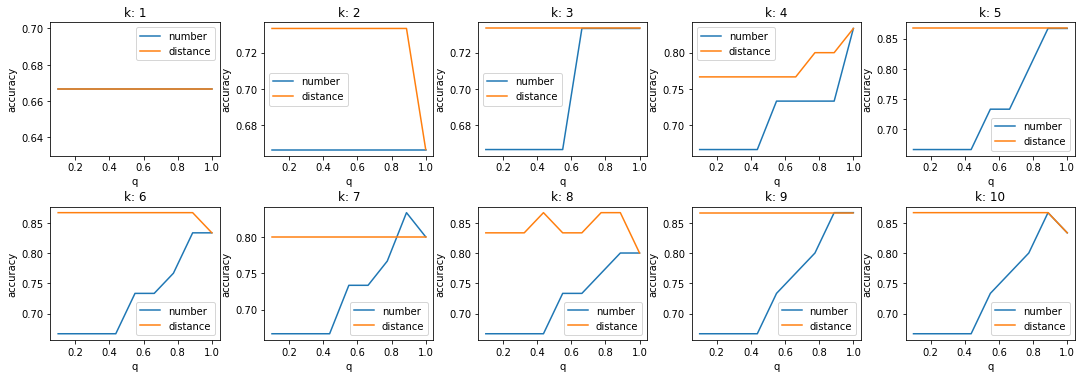

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.tight_layout(h_pad=3)
for k, ax in zip(range(1, 11), axes.ravel()):
  q_values = np.linspace(0.1, 1, 9)
  number_results = [run(k, q, 'number') for q in q_values]
  dist_results = [run(k, q, 'distance') for q in q_values]
  ax.set_xlabel('q')
  ax.set_ylabel('accuracy')
  ax.set_title(f'k: {k}')
  ax.plot(q_values, number_results, label='number')
  ax.plot(q_values, dist_results, label='distance')
  ax.legend()

Оптимальные значения гиперпараметров для обоих методов k = 5, q = 0.9
В целом, взвешивание по расстояниям при различеных значениях K и q имеет более высокую метрику и менее чувствительно к числу ближайших соседей
Сравним гиперплоскости для параметров при которых метрики отличаются

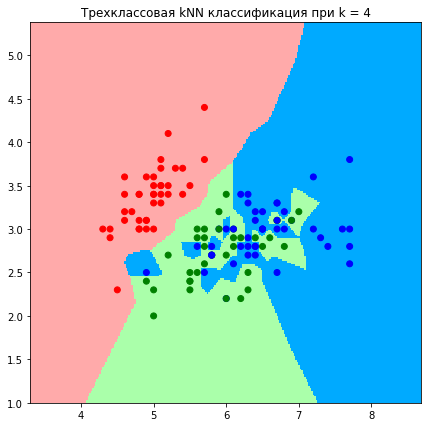

In [14]:
k = 4
q = 0.5
get_graph(X_train, y_train, k, q, weighted_knn_by_number)

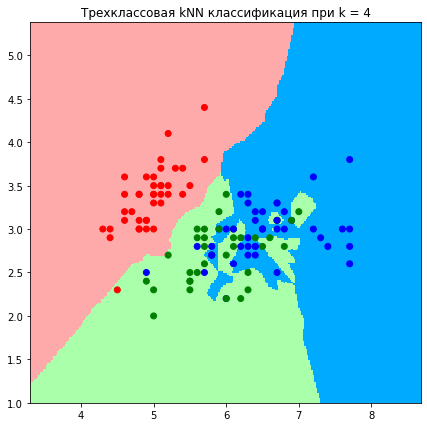

In [15]:
get_graph(X_train, y_train, k, q, weighted_knn_by_distance)

По полученным гиперплоскостям кажется что взвешивание по расстояниям менее склонно к переобучению на выбросах в данных

4 (опция). Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

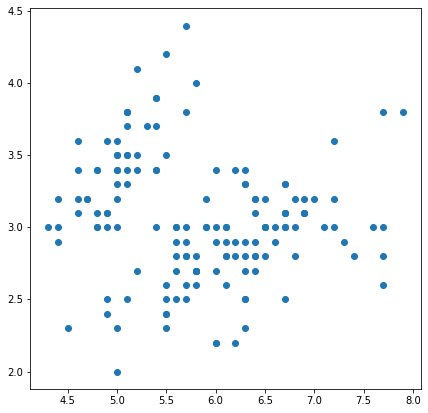

In [17]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [19]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [21]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

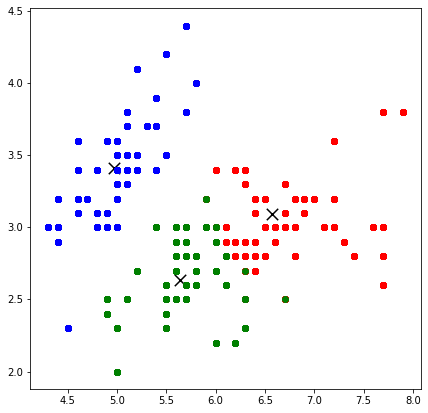

In [22]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [33]:
def mean_quadratic_intracluster_distance(centroids, clusters):
  metric = 0
  for i, cluster in clusters.items():
    squared_distances = 0
    for x in cluster:
      squared_distances += e_metrics(x, centroids[i]) ** 2
    metric += squared_distances / len(cluster)
  return metric

In [28]:
mean_quadratic_intracluster_distance(centroids, clusters)

0.8908065495449278

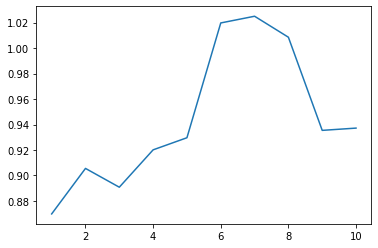

In [34]:
metrics = []
for k in range(1, 11):
  centroids, clusters = kmeans(X, k, max_iterations, min_distance)
  metrics.append(mean_quadratic_intracluster_distance(centroids, clusters))
plt.plot(range(1, 11), metrics)

Оптимальное значение метрики при k = 3, минимальное значение метрики при k = 1 (отсутствии кластеризации)